In [1]:
import yfinance as yf
import pandas as pd

In [26]:
Ticker = yf.Ticker('NVDA')
Ticker1 = yf.Ticker('AMZN')
Ticker2 = yf.Ticker('INTC')
data = Ticker.history(period='5y')
data1 = Ticker1.history(period='5y')
data2 = Ticker2.history(period='5y')
# ...existing code...
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data1 = data1[['Open', 'High', 'Low', 'Close', 'Volume']]
data2 = data2[['Open', 'High', 'Low', 'Close', 'Volume']]

data.columns = [f"NVDA_{col}" for col in data.columns]
data1.columns = [f"AMZN_{col}" for col in data1.columns]
data2.columns = [f"INTC_{col}" for col in data2.columns]

data.count()

NVDA_Open      1255
NVDA_High      1255
NVDA_Low       1255
NVDA_Close     1255
NVDA_Volume    1255
dtype: int64

In [27]:
# Concatenate the three dataframes along columns
combined_df = pd.concat([data, data1, data2], axis=1)

# Get the start date and calculate the end date for 3.5 years
start_date = combined_df.index.min()
end_date = start_date + pd.DateOffset(years=3, months=6)

# Filter the dataframe to only include the first 3.5 years
df_train = combined_df.loc[(combined_df.index >= start_date) & (combined_df.index < end_date)]

df_train.count()

NVDA_Open      880
NVDA_High      880
NVDA_Low       880
NVDA_Close     880
NVDA_Volume    880
AMZN_Open      880
AMZN_High      880
AMZN_Low       880
AMZN_Close     880
AMZN_Volume    880
INTC_Open      880
INTC_High      880
INTC_Low       880
INTC_Close     880
INTC_Volume    880
dtype: int64

In [28]:
# Get the last 1 year of data from combined_df
last_year_start = combined_df.index.max() - pd.DateOffset(years=1)
df_test = combined_df.loc[combined_df.index >= last_year_start]
df_test.count()

NVDA_Open      251
NVDA_High      251
NVDA_Low       251
NVDA_Close     251
NVDA_Volume    251
AMZN_Open      251
AMZN_High      251
AMZN_Low       251
AMZN_Close     251
AMZN_Volume    251
INTC_Open      251
INTC_High      251
INTC_Low       251
INTC_Close     251
INTC_Volume    251
dtype: int64

In [6]:
# from Environment import SuperiorTradingEnv
from Environment2 import SuperiorTradingEnv2
from stable_baselines3.common.vec_env import DummyVecEnv

In [29]:
# env = DummyVecEnv([lambda: SuperiorTradingEnv(df=df_train, window_size=50, initial_balance=10000)])
env2 = DummyVecEnv([lambda: SuperiorTradingEnv2(df=df_train, window_size=50, initial_balance=10000)])

c:\Users\kruth\Desktop\RL Project\.venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [8]:
from stable_baselines3 import PPO, A2C
import numpy as np

In [9]:
import optuna as opt

c:\Users\kruth\Desktop\RL Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def optimize_ppo(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    n_steps = trial.suggest_categorical('n_steps', [128, 256, 512, 1024, 2048])
    gamma = trial.suggest_uniform('gamma', 0.90, 0.9999)
    ent_coef = trial.suggest_loguniform('ent_coef', 1e-8, 1e-2)

    model = PPO(
        "MlpPolicy",
        env2,
        learning_rate=learning_rate,
        n_steps=n_steps,
        gamma=gamma,
        ent_coef=ent_coef,
        verbose=0
    )

    model.learn(total_timesteps=50000)

    obs = env2.reset()  # ✅ only obs
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env2.step(action)
        total_reward += reward

    return total_reward  # maximize profit

# Run Optuna study
study = opt.create_study(direction="maximize")
study.optimize(optimize_ppo, n_trials=20)

print("Best hyperparameters:", study.best_params)

In [11]:
best_params = {
'learning_rate': 0.0008869642478488519, 
'n_steps': 2048, 
'gamma': 0.901660419028813, 
'ent_coef': 1.810120309042738e-05      
}

model = PPO(
    'MlpPolicy',
    env2,
    learning_rate=best_params['learning_rate'],
    gamma=best_params['gamma'],
    ent_coef=best_params['ent_coef'],
    # batch_size=best_params['batch_size'],
    verbose=1
)
model.learn(total_timesteps=100000)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1077 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 816        |
|    iterations           | 2          |
|    time_elapsed         | 5          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.03683672 |
|    clip_fraction        | 0.271      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.25      |
|    explained_variance   | -15.4      |
|    learning_rate        | 0.000887   |
|    loss                 | -0.0666    |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0453    |
|    std                  | 0.99       |
|    value_loss           | 0.00743    |
-----------------------------------

In [30]:
env_test = DummyVecEnv([lambda: SuperiorTradingEnv2(df=df_test, window_size=50, initial_balance=10000)])

c:\Users\kruth\Desktop\RL Project\.venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Total Profit: 1154.694656363561
Episode 1 total reward: [0.02826083]


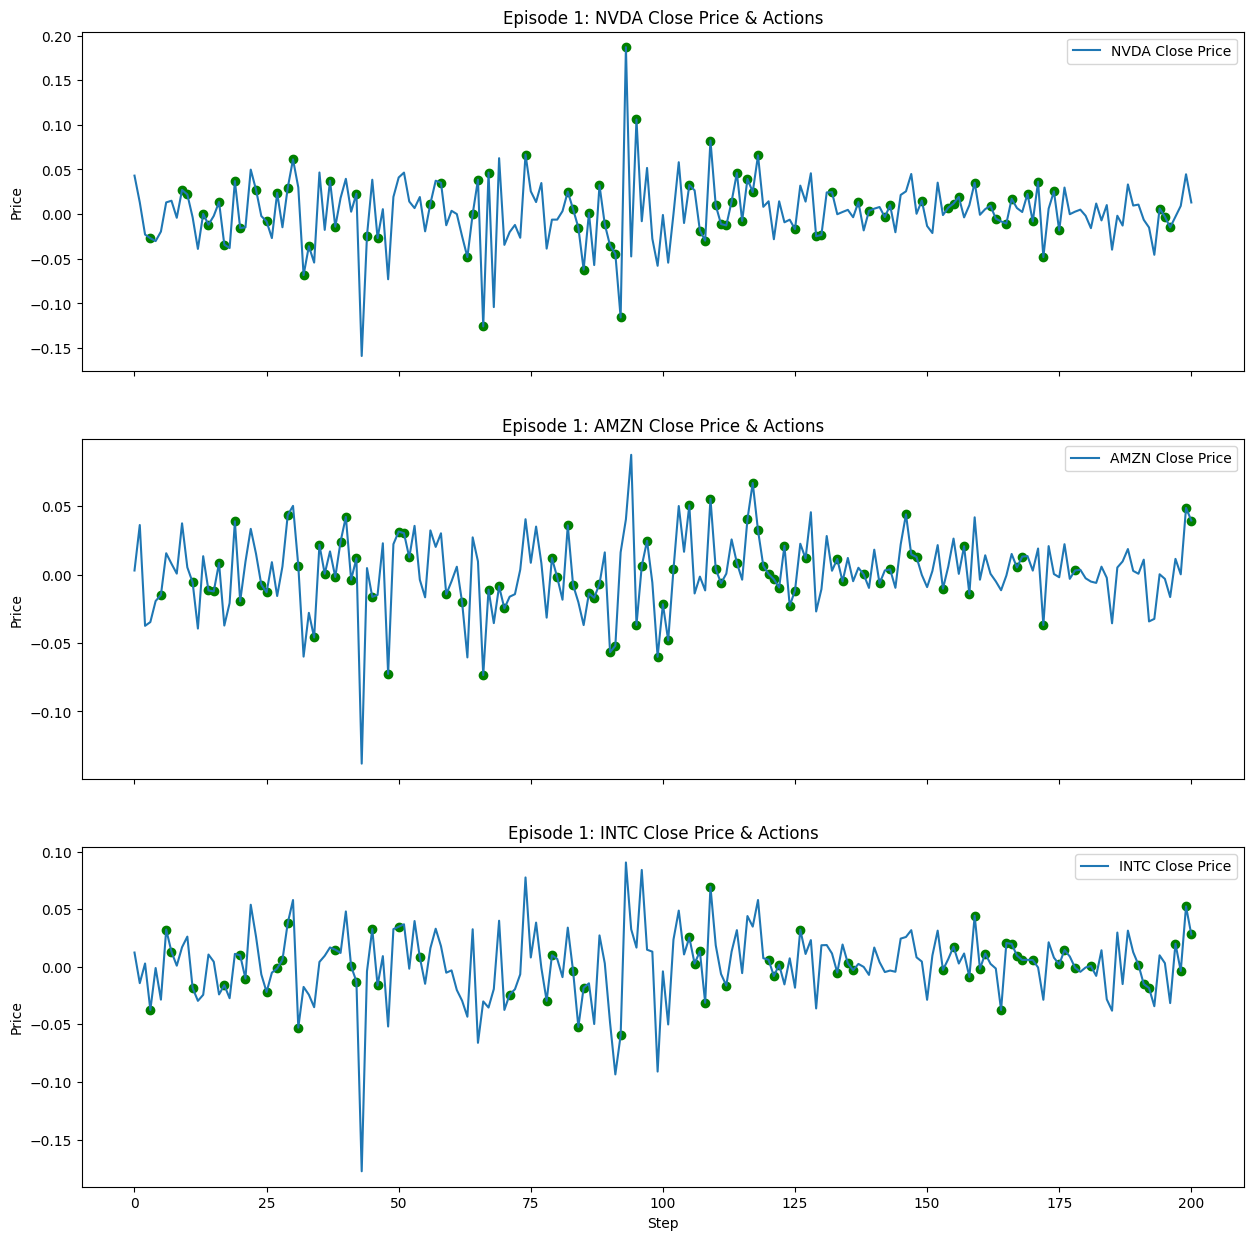

In [31]:
company_names = ['NVDA', 'AMZN', 'INTC']  # Adjust if you use different tickers
n_eval_episodes = 1  # Number of test episodes

for episode in range(n_eval_episodes):
    state = env_test.reset()
    done = False
    total_reward = 0
    obs_history = [[] for _ in range(len(company_names))]
    action_history = [[] for _ in range(len(company_names))]
    step = 0

    while not done:
        action, _ = model.predict(state, deterministic=True)
        state, reward, done, info = env_test.step(action)
        # action shape is (1, 3), so use action[0]
        asset_actions = action[0]
        obs = state[0][env_test.envs[0].window_size-1]
        # obs should be array-like, one value per asset
        for idx in range(len(company_names)):
            obs_history[idx].append(obs[idx])
            action_history[idx].append(asset_actions[idx])
        total_reward += reward
        total_profit= info[0].get('total_profit')
        step += 1
    print(f"Total Profit: {total_profit}")
    print(f"Episode {episode+1} total reward: {total_reward}")

    # Plotting for each company
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(len(company_names), 1, figsize=(15, 5 * len(company_names)), sharex=True)
    if len(company_names) == 1:
        axs = [axs]
    for idx, company in enumerate(company_names):
        axs[idx].plot(obs_history[idx], label=f'{company} Close Price')
        for i, act in enumerate(action_history[idx]):
            if act > 0.5:  # Buy
                axs[idx].scatter(i, obs_history[idx][i], color='green', label='Buy' if i == 0 else "")
            elif act < -0.5:  # Sell
                axs[idx].scatter(i, obs_history[idx][i], color='red', label='Sell' if i == 0 else "")
            # Hold: no scatter point
        axs[idx].legend()
        axs[idx].set_title(f'Episode {episode+1}: {company} Close Price & Actions')
        axs[idx].set_ylabel('Price')
    plt.xlabel('Step')
    plt.show()

In [17]:
model.save("ppo_trading_bot1")

In [18]:
model_1 = PPO.load("ppo_trading_bot1", env=env2)
# Continue training for more timesteps
model_1.learn(total_timesteps=100000, reset_num_timesteps=False)

# Save the updated model
# model_1.save("ppo_trading_bot1_continued")

-------------------------------
| time/              |        |
|    fps             | 1157   |
|    iterations      | 1      |
|    time_elapsed    | 1      |
|    total_timesteps | 102400 |
-------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 820       |
|    iterations           | 2         |
|    time_elapsed         | 4         |
|    total_timesteps      | 104448    |
| train/                  |           |
|    approx_kl            | 0.9512819 |
|    clip_fraction        | 0.772     |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.483     |
|    explained_variance   | 0.899     |
|    learning_rate        | 0.000887  |
|    loss                 | -0.0274   |
|    n_updates            | 500       |
|    policy_gradient_loss | -0.0228   |
|    std                  | 0.201     |
|    value_loss           | 3.91e-05  |
---------------------------------------
----------------

{'total_asset': np.float64(10000.0), 'balance': np.float64(10000.0), 'shares_held': array([0., 0., 0.], dtype=float32), 'step_return': np.float64(0.0), 'total_profit': np.float64(0.0), 'TimeLimit.truncated': False}
{'total_asset': np.float64(10000.0), 'balance': np.float64(10000.0), 'shares_held': array([0., 0., 0.], dtype=float32), 'step_return': np.float64(0.0), 'total_profit': np.float64(0.0), 'TimeLimit.truncated': False}
{'total_asset': np.float64(10000.0), 'balance': np.float64(10000.0), 'shares_held': array([0., 0., 0.], dtype=float32), 'step_return': np.float64(0.0), 'total_profit': np.float64(0.0), 'TimeLimit.truncated': False}
{'total_asset': np.float64(10000.0), 'balance': np.float64(10000.0), 'shares_held': array([0., 0., 0.], dtype=float32), 'step_return': np.float64(0.0), 'total_profit': np.float64(0.0), 'TimeLimit.truncated': False}
{'total_asset': np.float64(10000.0), 'balance': np.float64(10000.0), 'shares_held': array([0., 0., 0.], dtype=float32), 'step_return': np.fl

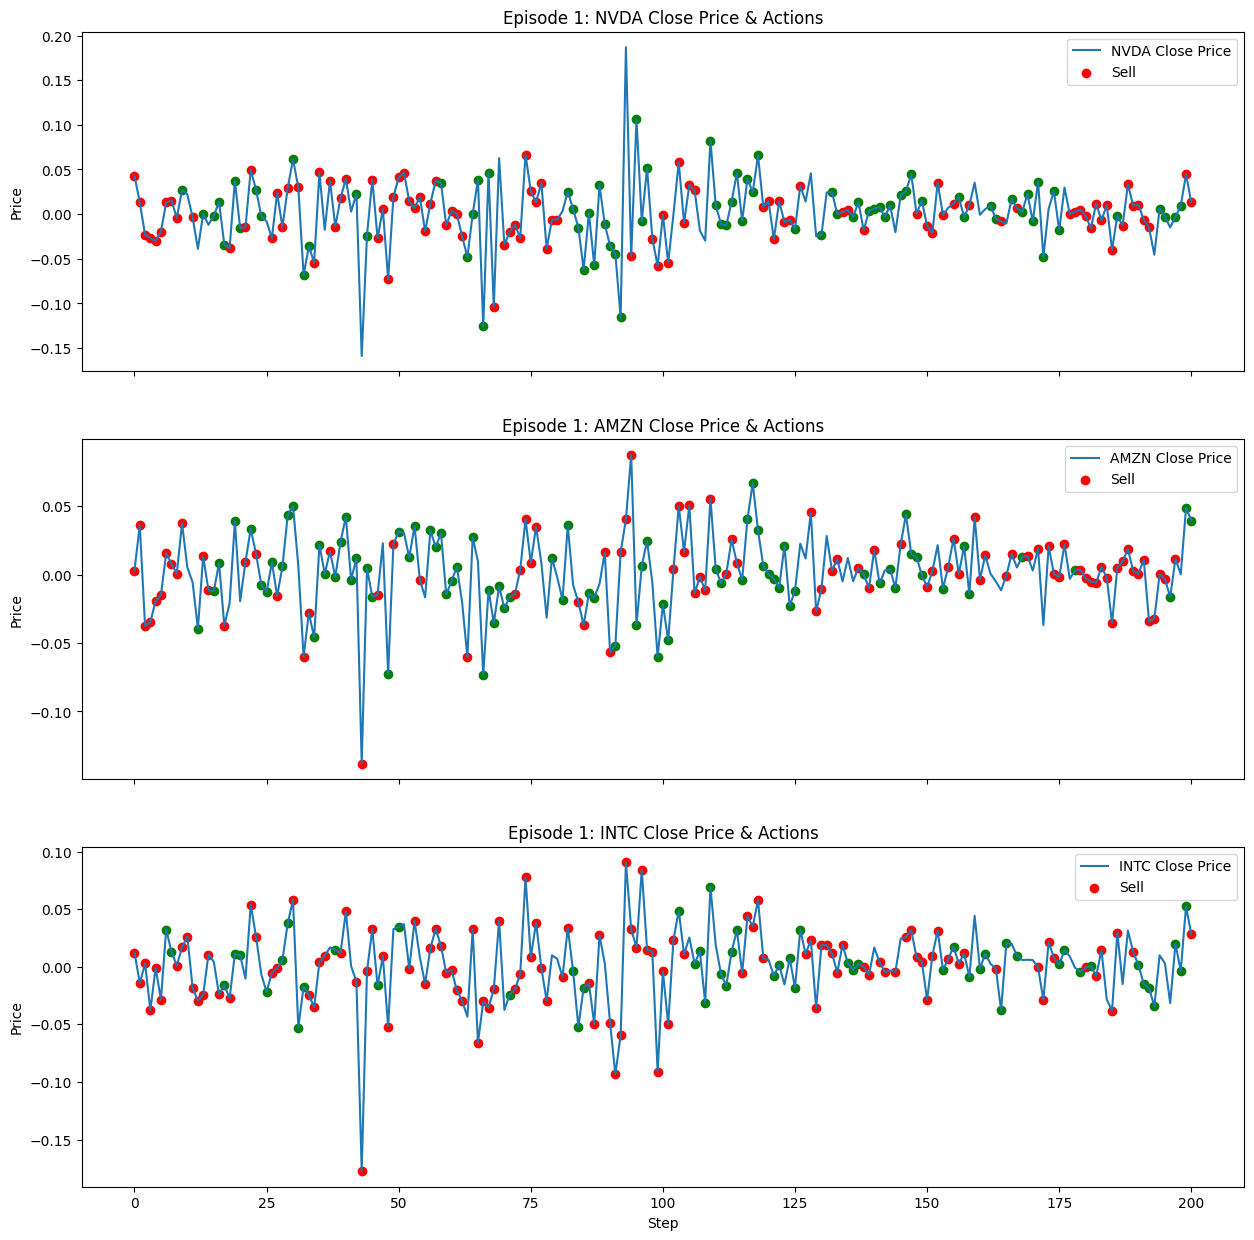

In [ ]:
company_names = ['NVDA', 'AMZN', 'INTC']  # Adjust if you use different tickers
n_eval_episodes = 1  # Number of test episodes

for episode in range(n_eval_episodes):
    state = env_test.reset()
    done = False
    total_reward = 0
    obs_history = [[] for _ in range(len(company_names))]
    action_history = [[] for _ in range(len(company_names))]
    step = 0

    while not done:
        action, _ = model_1.predict(state, deterministic=True)
        state, reward, done, info = env_test.step(action)
        # action shape is (1, 3), so use action[0]
        asset_actions = action[0]
        obs = state[0][env_test.envs[0].window_size-1]
        # print(info[0])
        # obs should be array-like, one value per asset
        for idx in range(len(company_names)):
            obs_history[idx].append(obs[idx])
            action_history[idx].append(asset_actions[idx])
        total_reward += reward
        total_profit= info[0].get('total_profit')
        step += 1
    print(f"Total Profit: {total_profit}")
    print(f"Episode {episode+1} total reward: {total_reward}")

    # Plotting for each company
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(len(company_names), 1, figsize=(15, 5 * len(company_names)), sharex=True)
    if len(company_names) == 1:
        axs = [axs]
    for idx, company in enumerate(company_names):
        axs[idx].plot(obs_history[idx], label=f'{company} Close Price')
        for i, act in enumerate(action_history[idx]):
            if act > 0.5:  # Buy
                axs[idx].scatter(i, obs_history[idx][i], color='green', label='Buy' if i == 0 else "")
            elif act < 0.1:  # Sell
                axs[idx].scatter(i, obs_history[idx][i], color='red', label='Sell' if i == 0 else "")
            # Hold: no scatter point
        axs[idx].legend()
        axs[idx].set_title(f'Episode {episode+1}: {company} Close Price & Actions')
        axs[idx].set_ylabel('Price')
    plt.xlabel('Step')
    plt.show()

In [25]:
model_1.save("ppo_trading_bot1_ext")